# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2) with Engineered Features from different distance metrics


This notebook provides a clustering for the total (n2) column of the acceleration data of all trips. The exact approach can be seen here.

----
**Specification of experiment:**
- scripted and ordinary trips
- n2 column of acceleration data was used
- Euclidean/cosine/correlation Distance was calculated and combined during the feature engineering
- Feature Engineering with Quantiles, Standard deviation of the different distance metrics, after that PCA was used for decorrelation

-----
**Results:**

1) KMeans Clustering:

    Estimated number of clusters: 5

    True number of clusters: 3

    Homogeneity: 0.297

    Completeness: 0.424

    V-measure: 0.349

    Adjusted MI: 0.296

    Silhouette Coefficient: 0.441
    
2) HDBSCAN Clustering:

    
    Estimated number of clusters: 3

    True number of clusters: 3

    Homogeneity: 0.352

    Completeness: 0.310

    V-measure: 0.330

    Adjusted MI: 0.309

    Silhouette Coefficient: 0.380



*Assume that transport modes are true clusters

In [15]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import hdbscan

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_silhouette_scores

%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set to true if all trips should be plotted at the end
plot_all_trips = False

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [4]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]


euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")
correlation_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="correlation")
cosine_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="cosine")

--------------
# Feature Engineering

## Summary Statistics of euclidean distances:

In [5]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_only = euclidean_distances.drop(categorical_columns,axis=1)


In [6]:
percentiles=[0.1*(i+1) for i in range(10)]
summaries_euclidean = trips_only.transpose().describe(percentiles=percentiles).T
summaries_euclidean = summaries_euclidean.drop(["count","min","max","mean"],axis=1)
summaries_euclidean.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,45.571907,6.592725,11.671220,14.280400,16.096563,18.216037,25.715053,73.099327,103.760440,118.078920,168.729605
1,45.631845,6.939125,10.390683,12.894615,14.476116,16.686338,24.427714,72.553589,103.159206,117.537131,167.822824
2,45.805061,5.851265,10.500663,13.029385,14.768853,16.914233,24.796279,72.703468,103.401745,117.751214,167.915836
3,46.055116,6.446537,8.512491,11.028059,12.726118,15.134580,23.282617,71.996049,102.586694,117.039126,166.760233
4,45.833305,7.200553,8.925239,11.132777,12.790077,15.216717,23.310149,71.824274,102.428992,117.013389,166.822958


## Summary Statistics of correlation distances:

In [7]:
summaries_corr = correlation_distances.drop(categorical_columns,axis=1).transpose().describe(percentiles=percentiles).T
summaries_corr = summaries_corr.drop(["count","min","max","mean"],axis=1)
summaries_corr.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,0.137840,0.854661,0.938082,0.971467,0.989307,1.004120,1.016999,1.037229,1.073538,1.130035,1.546471
1,0.085550,0.901843,0.943969,0.964317,0.983526,0.999431,1.014501,1.029737,1.054023,1.097467,1.369148
2,0.092682,0.903578,0.940866,0.965669,0.982988,1.000083,1.019759,1.039322,1.064633,1.106871,1.451324
3,0.155308,0.830105,0.915406,0.958276,0.981802,1.000826,1.021906,1.045363,1.084079,1.161355,1.767814
4,0.074860,0.918032,0.949710,0.969912,0.986772,1.001577,1.016542,1.031553,1.051401,1.086370,1.323634


## Summary Statistics of cosine distances

In [8]:
summaries_cosine = cosine_distances.drop(categorical_columns,axis=1).transpose().describe(percentiles=percentiles).T
summaries_cosine = summaries_cosine.drop(["count","min","max","mean"],axis=1)
summaries_cosine.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%
0,0.033809,0.000055,0.000080,0.000113,0.000183,0.000485,0.003307,0.033883,0.061864,0.080240,0.112580
1,0.033815,0.000171,0.000195,0.000231,0.000298,0.000588,0.003371,0.034139,0.062317,0.080620,0.114187
2,0.033815,0.000048,0.000071,0.000105,0.000177,0.000469,0.003318,0.033969,0.062184,0.080353,0.112795
3,0.033804,0.000068,0.000094,0.000127,0.000197,0.000502,0.003282,0.034100,0.061970,0.080214,0.112340
4,0.033820,0.000186,0.000209,0.000244,0.000317,0.000624,0.003385,0.034234,0.062124,0.080718,0.112961


## Use Correlation distance, cosine distance and euclidean distance summary features together

In [9]:
summaries = deepcopy(summaries_euclidean)
for name in summaries_euclidean.columns:
    summaries["cor_"+name] = summaries_corr[name]
    summaries["cosine_"+name]=summaries_cosine[name]
summaries.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,...,cor_60.0%,cosine_60.0%,cor_70%,cosine_70%,cor_80%,cosine_80%,cor_90%,cosine_90%,cor_100%,cosine_100%
0,45.571907,6.592725,11.671220,14.280400,16.096563,18.216037,25.715053,73.099327,103.760440,118.078920,...,1.016999,0.003307,1.037229,0.033883,1.073538,0.061864,1.130035,0.080240,1.546471,0.112580
1,45.631845,6.939125,10.390683,12.894615,14.476116,16.686338,24.427714,72.553589,103.159206,117.537131,...,1.014501,0.003371,1.029737,0.034139,1.054023,0.062317,1.097467,0.080620,1.369148,0.114187
2,45.805061,5.851265,10.500663,13.029385,14.768853,16.914233,24.796279,72.703468,103.401745,117.751214,...,1.019759,0.003318,1.039322,0.033969,1.064633,0.062184,1.106871,0.080353,1.451324,0.112795
3,46.055116,6.446537,8.512491,11.028059,12.726118,15.134580,23.282617,71.996049,102.586694,117.039126,...,1.021906,0.003282,1.045363,0.034100,1.084079,0.061970,1.161355,0.080214,1.767814,0.112340
4,45.833305,7.200553,8.925239,11.132777,12.790077,15.216717,23.310149,71.824274,102.428992,117.013389,...,1.016542,0.003385,1.031553,0.034234,1.051401,0.062124,1.086370,0.080718,1.323634,0.112961


In [10]:
from sklearn.preprocessing import scale

summaries_scaled = pd.DataFrame(scale(summaries),columns=summaries.columns)
summaries_scaled.head()

,std,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,...,cor_60.0%,cosine_60.0%,cor_70%,cosine_70%,cor_80%,cosine_80%,cor_90%,cosine_90%,cor_100%,cosine_100%
0,0.781653,-0.729561,-0.656575,-0.631521,-0.638780,-0.673788,-0.680514,-0.577151,-0.528720,-0.525668,...,2.174829,-0.686578,2.450803,-0.688203,2.800435,-0.699222,1.932760,-0.690828,1.570947,-0.672033
1,0.786974,-0.722130,-0.684420,-0.661966,-0.675033,-0.708919,-0.712014,-0.597806,-0.557837,-0.553245,...,1.443934,-0.684698,1.304567,-0.680137,1.167893,-0.684532,0.735452,-0.678810,0.201441,-0.636461
2,0.802353,-0.745467,-0.682028,-0.659005,-0.668484,-0.703685,-0.702996,-0.592133,-0.546092,-0.542348,...,2.982438,-0.686265,2.770899,-0.685503,2.055478,-0.688864,1.081185,-0.687272,0.836103,-0.667284
3,0.824554,-0.732697,-0.725261,-0.702973,-0.714185,-0.744555,-0.740035,-0.618908,-0.585563,-0.578594,...,3.610668,-0.687335,3.695089,-0.681366,3.682216,-0.695777,3.084177,-0.691667,3.280416,-0.677348
4,0.804861,-0.716522,-0.716286,-0.700672,-0.712754,-0.742669,-0.739361,-0.625409,-0.593201,-0.579904,...,2.041010,-0.684264,1.582456,-0.677142,0.948573,-0.690785,0.327504,-0.675731,-0.150069,-0.663606


## Apply PCA  to summaries to get decorrelated features

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
summaries_reduced = pd.DataFrame(pca.fit_transform(summaries_scaled))

features_used = summaries_reduced
print("Explained Variance Ratio: {}".format(pca.explained_variance_ratio_))

Explained Variance Ratio: [ 0.70992274  0.16742194  0.05680277  0.04236188]


------
## Create Base Model with KMeans Clustering

Use summaries of each distance

In [19]:
from sklearn.cluster import KMeans
random_state = 0

clustering_labels = []
numbers_of_k = [3,4,5,6]
for k in numbers_of_k:
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(features_used)
    clustering_labels.append(kmeans.labels_)
    


### Plot Silhouette Score for different k

For n_clusters = 3 The average silhouette_score is : 0.392422343526


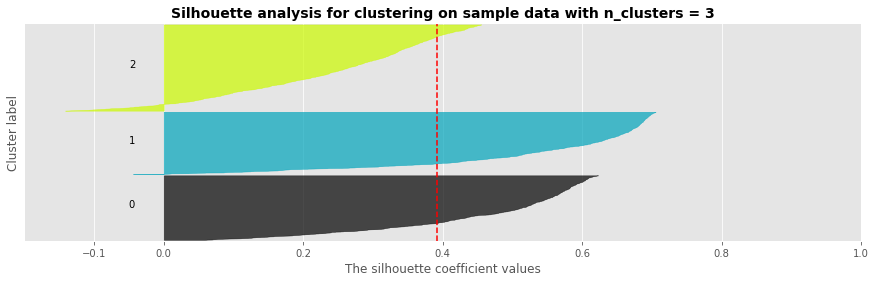

For n_clusters = 4 The average silhouette_score is : 0.378588211953


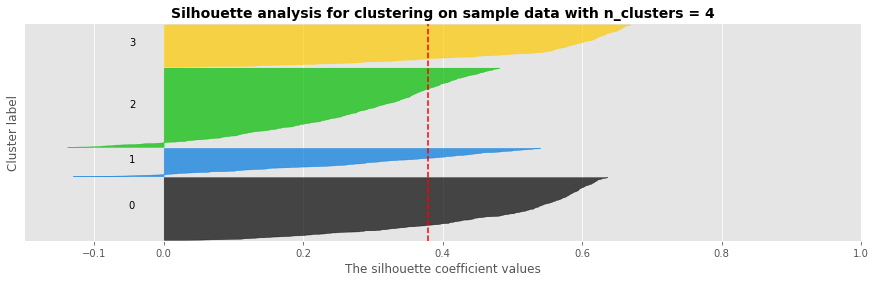

For n_clusters = 5 The average silhouette_score is : 0.396895206111


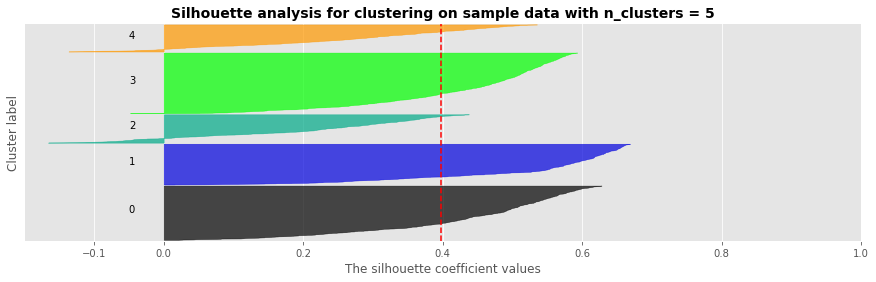

For n_clusters = 6 The average silhouette_score is : 0.405817508589


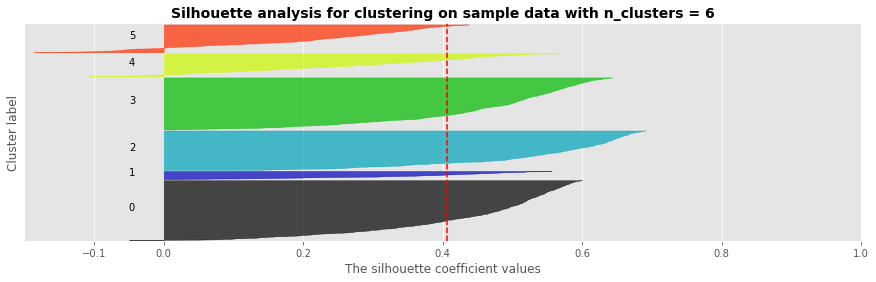

In [20]:
plot_silhouette_scores(features_used, clustering_labels, figsize=(15,4))

Use best parameters:

In [22]:
kmeans = KMeans(n_clusters=6, random_state=random_state).fit(features_used)
euclidean_distances["cluster_labels"]=kmeans.labels_

## Visualise Clustering on 2D - TSNE Plot:

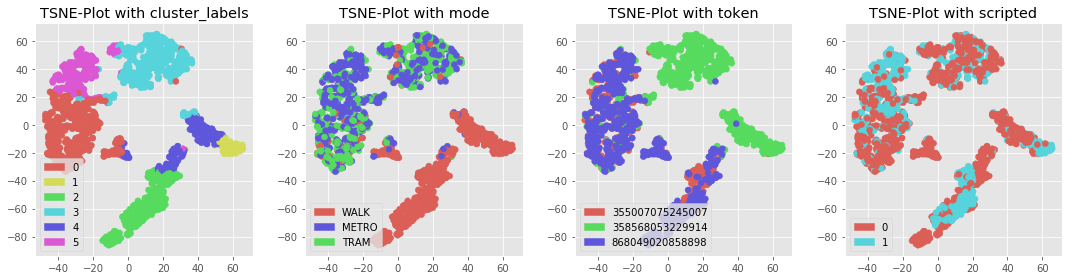

In [23]:
color_encodings = euclidean_distances.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings)

### Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [25]:
cluster_performance = get_clustering_performance(features_used, euclidean_distances["cluster_labels"],
                           true_labels=euclidean_distances["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 6

 - True number of clusters: 3

 - Homogeneity: 0.293

 - Completeness: 0.445

 - V-measure: 0.353

 - Adjusted MI: 0.292

 - Silhouette Coefficient: 0.406

## Plot the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [26]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

,count_cluster_0,count_cluster_1,count_cluster_2,count_cluster_3,count_cluster_4,count_cluster_5,mode
0,216.0,1.0,0.0,184.0,6.0,189.0,METRO
1,93.0,83.0,402.0,34.0,227.0,1.0,WALK
2,298.0,0.0,0.0,312.0,2.0,94.0,TRAM


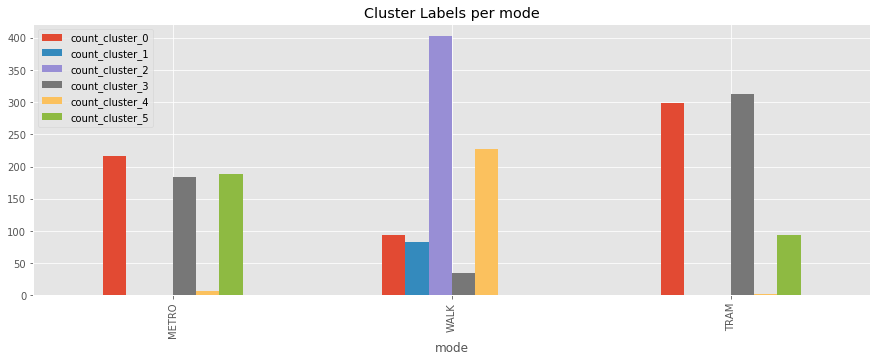

In [27]:
plot_distribution_of_cluster_labels_for_target("mode", euclidean_distances)

## Plot distribution of cluster labels for scripted and tokens

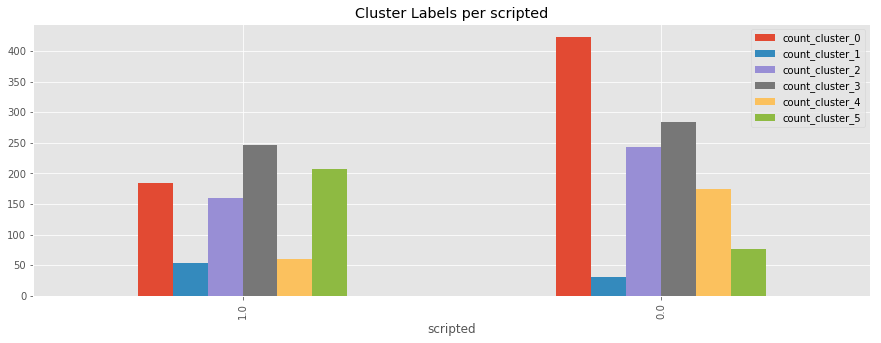

In [28]:
plot_distribution_of_cluster_labels_for_target("scripted", euclidean_distances)

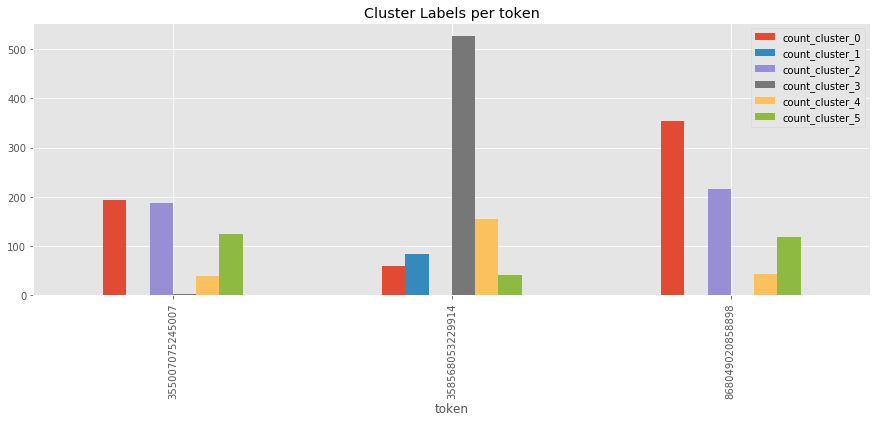

In [29]:
plot_distribution_of_cluster_labels_for_target("token", euclidean_distances)

------------
## Create Model with HDBSCAN Clustering

In [46]:
clustering_labels = []
min_cluster_sizes = [10,15,250]
for k in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=k, gen_min_span_tree=True)
    clusterer.fit(features_used)
    clustering_labels.append(clusterer.labels_)
    print("For MinClusterSize: {} we have the {} clusters".format(k,len(set(clusterer.labels_))))
    



For MinClusterSize: 10 we have the 5 clusters
For MinClusterSize: 15 we have the 5 clusters
For MinClusterSize: 250 we have the 3 clusters


For n_clusters = 5 The average silhouette_score is : 0.300200207854


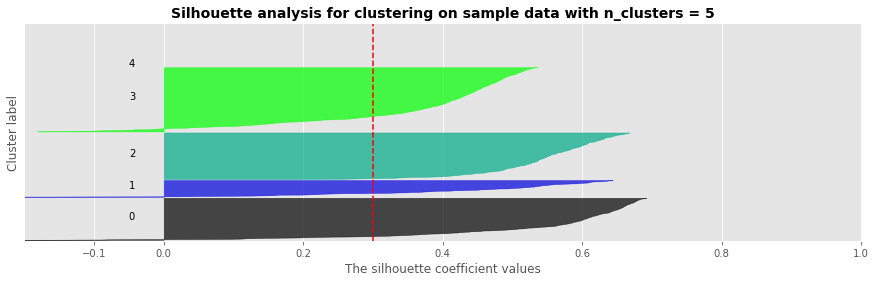

For n_clusters = 5 The average silhouette_score is : 0.274310562275


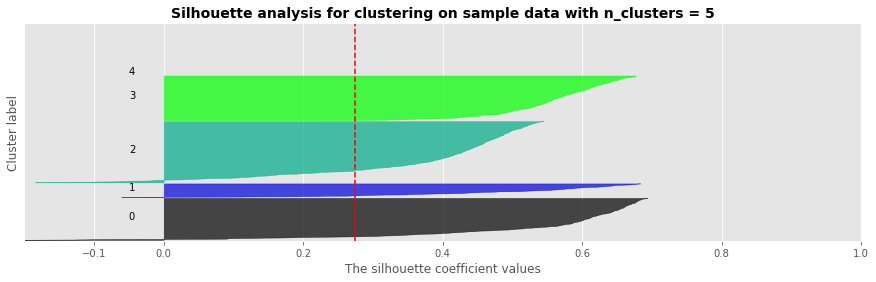

For n_clusters = 3 The average silhouette_score is : 0.380035134917


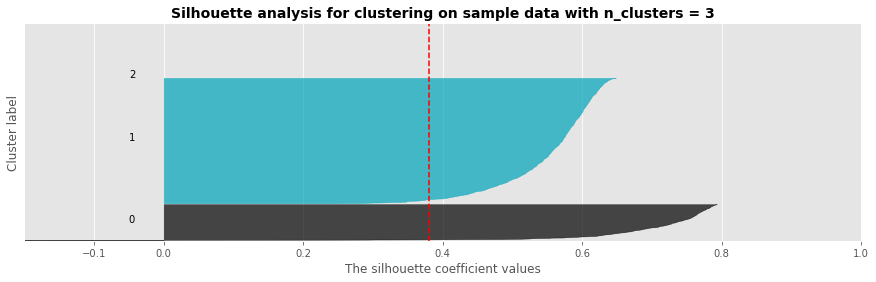

In [47]:
plot_silhouette_scores(features_used, clustering_labels, figsize=(15,4))

Use best parameters:

In [48]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=250, gen_min_span_tree=True)
clusterer.fit(features_used)
euclidean_distances["cluster_labels"]=clusterer.labels_

### Summary Statistics for HDBSCAN Clustering:

In [49]:
cluster_performance = get_clustering_performance(features_used, euclidean_distances["cluster_labels"],
                           true_labels=euclidean_distances["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 3

 - True number of clusters: 3

 - Homogeneity: 0.352

 - Completeness: 0.310

 - V-measure: 0.330

 - Adjusted MI: 0.309

 - Silhouette Coefficient: 0.380

## Visualise Clustering on 2D - TSNE Plot:

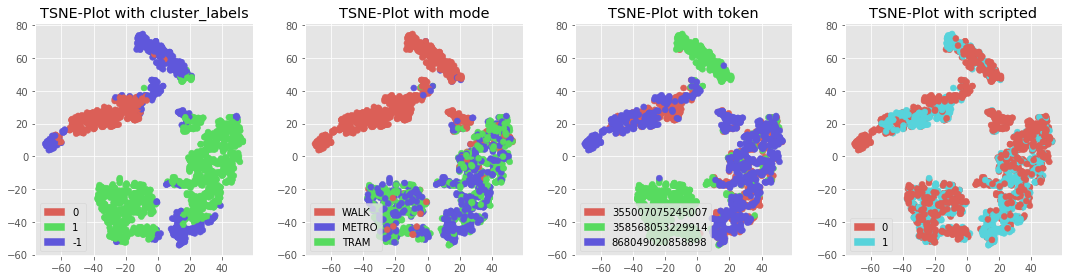

In [34]:
color_encodings = euclidean_distances.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings)

In [35]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", euclidean_distances)
mode_dist_df

,count_cluster_-1,count_cluster_0,count_cluster_1,mode
0,116.0,1.0,479.0,METRO
1,361.0,357.0,122.0,WALK
2,50.0,0.0,656.0,TRAM


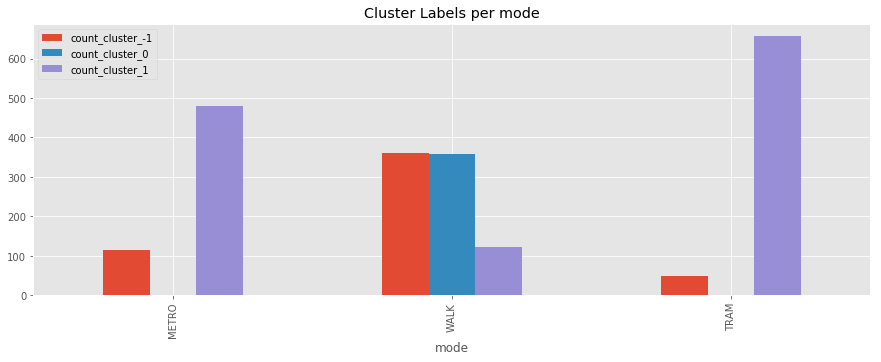

In [36]:
plot_distribution_of_cluster_labels_for_target("mode", euclidean_distances)

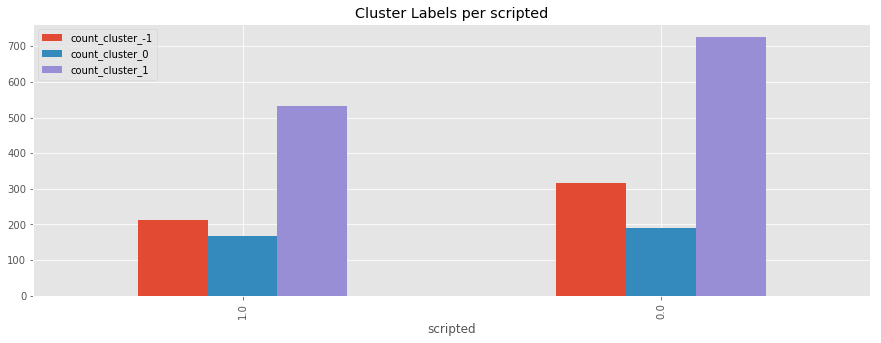

In [37]:
plot_distribution_of_cluster_labels_for_target("scripted", euclidean_distances)

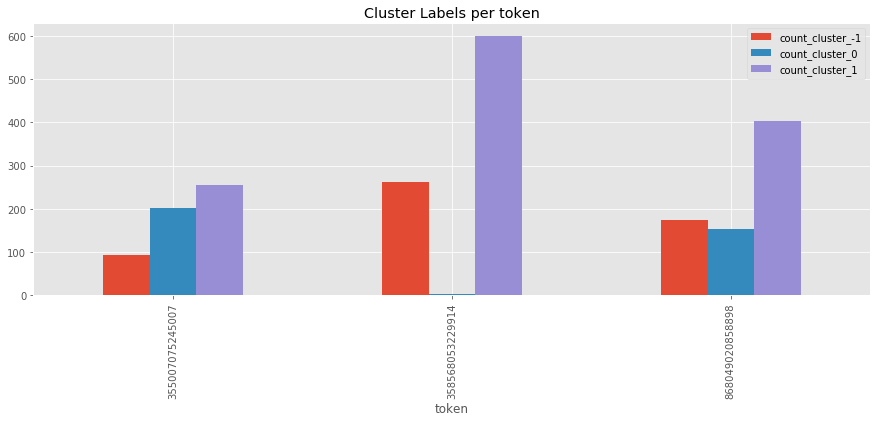

In [38]:
plot_distribution_of_cluster_labels_for_target("token", euclidean_distances)

## Plot all trips with their clustering labels

Produce this plot more conveniently by writing:

In [39]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, euclidean_distances)
